In [ ]:
# Assignment #3
# Convolutional Neural Networks
# In this assignment, you will be experimenting with a Convolutional Neural Network

# Detect cacti from drone video footage
# Here is a link to a research project that wants to use drone sourced image data to find out where cacti live in Mexican deserts
# https://jivg.org/research-projects/vigia/
# https://www.sciencedirect.com/science/article/abs/pii/S1574954119300895?via%3Dihub 

# Here is a Kaggle challenge created from this research
# https://www.kaggle.com/competitions/aerial-cactus-identification/

# Preparations:
# Background information
#1) Check the website on the original research project (first paragraph only).
#2) Check Kaggle overview.
#3) Read this blog on creating a classifier for the cactus data set
# https://www.pluralsight.com/guides/image-classification-with-pytorch

# Setting up Colab
#2) Download the data from the class GitHub site:
# https://github.com/realtechsupport/CriticalMachineLearning/blob/main/various_datasets/aerial-cactus-identification.zip
#2b) Create a folder on your Google drive: A3.
#2c) Upload the zipped data file to that folder.
#3) Change runtime type to GPU to run the code in this notebook.

# Test
# Run the code block below.

# Assignment
# Proceed to the questions below.

In [ ]:
import os
import pandas
import matplotlib.pyplot as plt 
import matplotlib.image as img
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#set the data paths ( ++ adjust for your system ++)
root = '/content/drive/My Drive/Colab/ML/'
datapath = root + 'data/'
datapathA3 = datapath + 'A3/'

In [ ]:
# >>run this section only once to unzip all the training and test data <<
# This process takes about 3-4 minutes

import shutil

for r, d, f in os.walk(datapathA3):
    for file in f:
        if file.endswith(".zip"):
          print('unpacking...', file)
          shutil.unpack_archive(datapathA3+file, datapathA3)
        else:
          print('not touching...', file)


# a second time for the zip in zip folder files
for r, d, f in os.walk(datapathA3):
    for file in f:
        if file.endswith(".zip"):
          print('unpacking...', file)
          shutil.unpack_archive(datapathA3+file, datapathA3)
        else:
          print('not touching...', file)

unpacking... aerial-cactus-identification.zip
unpacking... aerial-cactus-identification.zip
not touching... sample_submission.csv
unpacking... test.zip
not touching... train.csv
unpacking... train.zip


After running the cell above, your A3 folder should look like this (FYI - It will take a while  {upto 45 minutes} before the train folder appears on your drive):
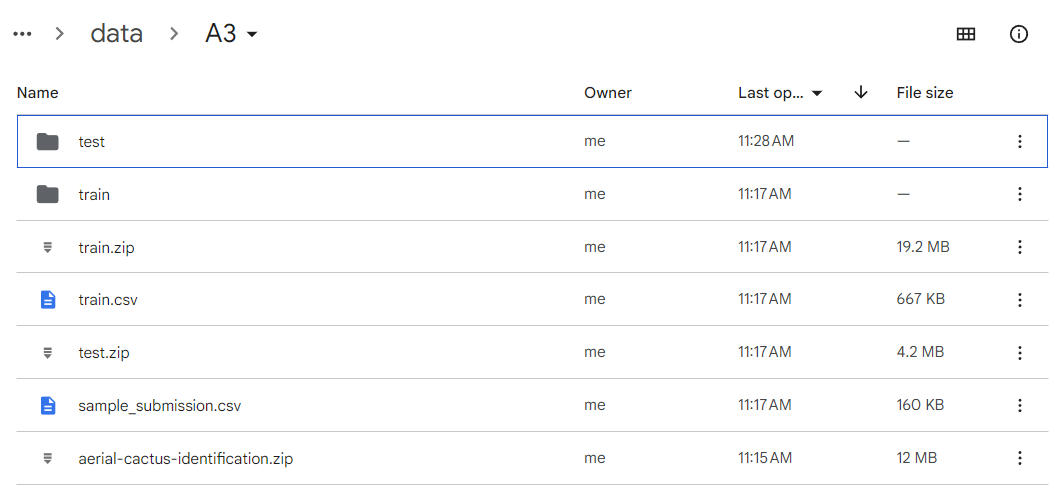


In [ ]:
# Read in the data and set the paths
labels = pandas.read_csv(datapathA3 + 'train.csv')
submission = pandas.read_csv(datapathA3 + 'sample_submission.csv')

train_path = datapathA3 + 'train/'
test_path = datapathA3 + 'test/'

In [ ]:
# Group the data according to the labels
label = 'Cactus detected', 'No Cactus detected'
plt.figure(figsize = (8,8))
plt.pie(labels.groupby('has_cactus').size(), labels = label, autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

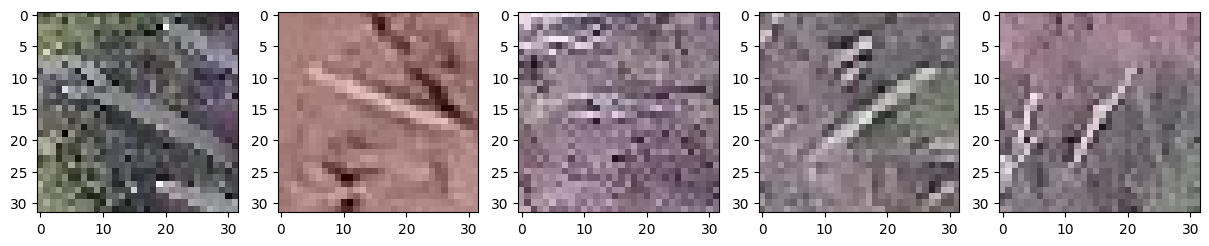

In [ ]:
#show some of the images

fig,ax = plt.subplots(1,5,figsize = (15,3))

for i,idx in enumerate(labels[labels['has_cactus'] == 1]['id'][-5:]):
    path = os.path.join(train_path,idx)
    ax[i].imshow(img.imread(path));

In [ ]:
class CactiDataset(Dataset):
    def __init__(self, data, path , transform = None):
        super().__init__()
        self.data = data.values
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return (len(self.data))
    
    def __getitem__(self,index):
        img_name,label = self.data[index]
        img_path = os.path.join(self.path, img_name)
        image = img.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return (image, label)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    #check if necessary
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return (ax)

In [ ]:
train_transform = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor(),transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])
test_transform = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor(),transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])
valid_transform = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor(),transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

In [ ]:
train, valid_data = train_test_split(labels, stratify=labels.has_cactus, test_size=0.2)

train_data = CactiDataset(train, train_path, train_transform )
valid_data = CactiDataset(valid_data, train_path, valid_transform )
test_data = CactiDataset(submission, test_path, test_transform )

In [ ]:
# Hyper parameters
num_epochs = 2                      # increase this once your setup is tested
num_classes = 2                     # Cactus or No-cactus
batch_size = 25
learning_rate = 0.002

In [ ]:
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset = valid_data, batch_size = batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle=False, num_workers=0)

In [ ]:
# Check to ensure you have the GPU ('cuda:0') hardware active
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a neural network model class
# This is very similar to the models used in our class experiments

class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(720, 1024)
        #hmm  ... maybe one could add another layer here?
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return (x)

In [ ]:
model = CNN()
print(model)

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

CNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=720, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)


In [ ]:
# This training process takes about 2 minutes if epoches = 2 AND GPU enabled

# Two arrays to keep track of the training and testing / validation losses 
train_losses = []
valid_losses = []

# Train the model
for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    for data, target in train_loader:
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-single-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    model.eval()
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss));

Epoch: 1 	Training Loss: 0.066846 	Validation Loss: 0.058629
Epoch: 2 	Training Loss: 0.068170 	Validation Loss: 0.065182


In [ ]:
# Test the model
model.eval()   

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        # this is the inference
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

# Save the model - It will take a while before the saved model is visiable on your Gdrive.
modelpath = datapathA3 + 'cactusmodel.pt'
torch.save(model.state_dict(), modelpath)

Test Accuracy of the model: 97.65714285714286 %


In [ ]:
#plot the network training
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

Your assignment consists in performing a few experiments and responding to the questions below.

**1)** Run this code and making sure it works.

**2)** Change the number of epochs. When does the network stop learning? 
[1 point]

**3)** Change the learning rate. What do you observe? 
[1 point]

**4)** Look more closely at the CNN model. 

4a) Read up on the function 'Dropout2d' 
https://pytorch.org/docs/stable/nn.html#dropout-layers.

Comment out that line and see how it impacts the performance of the training. 
[1 point]

4b) Read up on the function 'CrossEntropyLoss'
https://pytorch.org/docs/stable/nn.html#loss-functions

Pick a different loss function and train the network. What do you observe?
[2 points]

**5)** After reading the description of the original research, suggest 3 ways by which to make this research project more effective. 
[5 points]

**6)** Create an alternate CNN model for this classification problem. You can use any other model available, or just change some of the features of the given model. Train the network and compare results with the original CNN model. Add another type of performance metric or visualization, if you can.
[10 points]


**Send a link to your Colab notebook before Monday, APRIL 24th, noon.**



